# Imports

In [208]:
import os
import warnings
from collections import defaultdict
from copy import deepcopy
from datetime import datetime

import numpy as np
from scipy.interpolate import interp1d

from classify import temperature
from classify.data.responses import responses_to_traffic_array
from classify.data.traffic import load_traffic
from classify.scenario.bridge import healthy_damage, pier_disp_damage
from classify.scenario.traffic import normal_traffic
from model.bridge import Point
from model.bridge.bridge_705 import bridge_705_3d, bridge_705_med_config
from model.response import ResponseType
from plot import equal_lims, legend_marker_size, plt
from util import print_i, resize_units

warnings.filterwarnings("ignore")

In [209]:
c = bridge_705_med_config(bridge_705_3d)
# Set the directory of where to save/load responses.
c.root_generated_data_dir = os.path.join("/Users/jeremy/Desktop/mesh-med-600-mar", c.root_generated_data_dir)

sensor_point = Point(x=21, y=0, z=-8.4)  # Sensor point to investigate.

INFO: Loaded vehicle data from /Users/jeremy/cs/bridge-dss/data/a16-data/a16.csv in 0.12s
WARN: Vehicle PDF sums to 99.5, adjusted to sum to 1


# Response type aliases

In [210]:
# Short aliases for response types.
rt_y = ResponseType.YTranslation
rt_s = ResponseType.Strain

# Create functions to resize, and unit strings, for each response type.
resize_y, units_y = resize_units(rt_y.units())
resize_s, _ = resize_units(rt_s.units())

# Temperature data

In [211]:
# Load minute-by-minute temperature data for the year.
from_ = datetime.fromisoformat(f"2019-01-01T00:00")
to = datetime.fromisoformat(f"2019-12-31T23:59")
temps_2019 = temperature.from_to_mins(temperature.load("holly-springs"), from_, to)
temps_2019["temp"] = temperature.resize(temps_2019["temp"])

Temperature (0.001, 0.999) quantiles = -9.5, 34.5


In [212]:
# Effect of annual temperature.
effect_2019_y = resize_y(temperature.effect(c=c, response_type=rt_y, points=[sensor_point], temps=temps_2019["temp"], solar=temps_2019["solar"], len_per_hour=60)[0])
effect_2019_s = temperature.effect(c=c, response_type=rt_s, points=[sensor_point], temps=temps_2019["temp"], solar=temps_2019["solar"], len_per_hour=60)[0]
assert len(temps_2019) == len(effect_2019_y)

# Traffic data

In [213]:
total_mins = 24
total_seconds = total_mins * 60
traffic_scenario = normal_traffic(c=c, lam=5, min_d=2)
traffic_sequence_0, traffic_0, traffic_array_0 = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
)
traffic_sequence_1, traffic_1, traffic_array_1 = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
    add="1"
)
traffic_array_0.shape, traffic_array_1.shape

/Users/jeremy/Desktop/mesh-med-600-mar/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-1440-0,01.npy
/Users/jeremy/Desktop/mesh-med-600-mar/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-1440-0,01.npy


((144001, 2400), (144001, 2400))

# Temperature effect: July & December

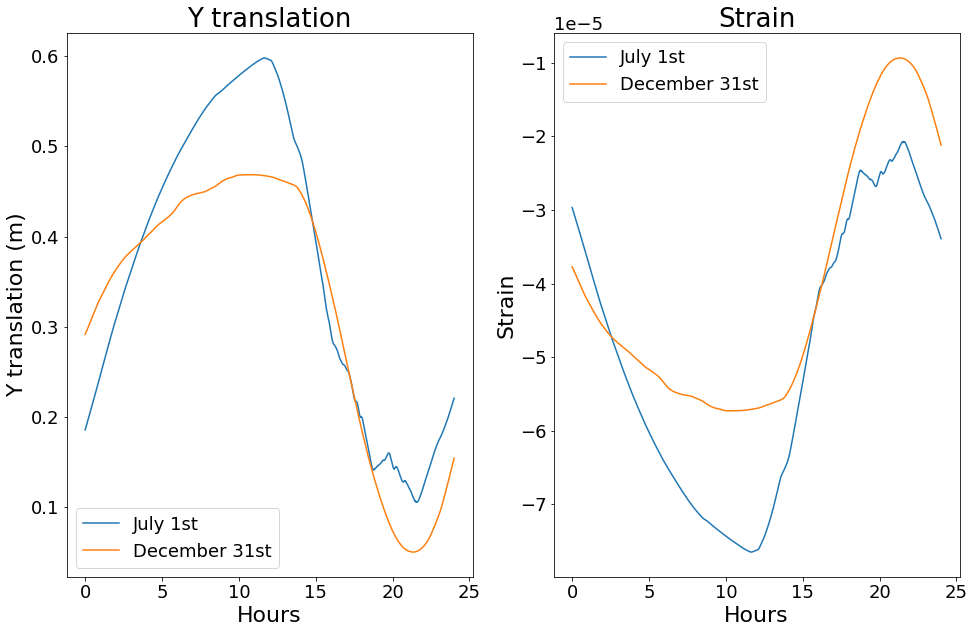

In [214]:
########
# July #
########

# Indices for beginning of July.
from_ = datetime.fromisoformat(f"2019-07-01T00:00")
to = datetime.fromisoformat(f"2019-07-01T23:59")
july_2019_i, july_2019_j = temperature.from_to_indices(temps_2019, from_, to)

# Effect at beginning of July.
effect_july_2019_y = effect_2019_y[july_2019_i:july_2019_j]
effect_july_2019_s = effect_2019_s[july_2019_i:july_2019_j]

temp_effect_july_y = temperature.apply(effect=effect_july_2019_y, responses=traffic_array_1)
temp_effect_july_s = temperature.apply(effect=effect_july_2019_s, responses=traffic_array_0)

############
# December #
############

# Indices for end of December.
from_ = datetime.fromisoformat(f"2019-12-31T00:00")
to = datetime.fromisoformat(f"2019-12-31T23:59")
dec_2019_i, dec_2019_j = temperature.from_to_indices(temps_2019, from_, to)

# Effect at end of December.
effect_dec_2019_y = effect_2019_y[dec_2019_i:dec_2019_j]
effect_dec_2019_s = effect_2019_s[dec_2019_i:dec_2019_j]

temp_effect_dec_y = temperature.apply(effect=effect_dec_2019_y, responses=traffic_array_0)
temp_effect_dec_s = temperature.apply(effect=effect_dec_2019_s, responses=traffic_array_0)

# Plot to be sure.
x = np.arange(len(temp_effect_dec_y)) * c.sensor_hz / 60
plt.landscape()
plt.subplot(1, 2, 1)
plt.plot(x, temp_effect_july_y, label="July 1st")
plt.plot(x, temp_effect_dec_y, label="December 31st")
plt.ylabel(f"Y translation ({rt_y.units()})")
plt.xlabel("Hours")
plt.title("Y translation")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, temp_effect_july_s, label="July 1st")
plt.plot(x, temp_effect_dec_s, label="December 31st")
plt.ylabel("Strain")
plt.xlabel("Hours")
plt.title("Strain")
plt.legend()

# Collecting responses to traffic: healthy x2 + damaged

In [215]:
damage_scenarios = [healthy_damage, healthy_damage, pier_disp_damage([(5, 1 / 1000)])]
traffic_arrays = [traffic_array_0, traffic_array_1, traffic_array_1]
damage_names = ["Healthy", "Healthy", "Pier settlement"]
assert len(damage_scenarios) == len(traffic_arrays)
assert len(damage_scenarios) == len(damage_names)
response_types = [rt_y, rt_s]

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, (damage_scenario, traffic_array) in enumerate(zip(damage_scenarios, traffic_arrays)):
    for r_i, response_type in enumerate(response_types):
        responses[d_i][r_i] = responses_to_traffic_array(
            c=damage_scenario.use(c)[0],
            traffic_array=traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=[sensor_point],
        ).T[0]  # Responses from a single point.
responses = np.array(responses)
responses.shape

(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)
(2400, 1)
(144001, 2400)uilt FEMResponses in 0.01s, (ResponseType.YTranslation)
(2400, 1)


(3, 2, 144001)

# Clustering: without temperature

In [216]:
# A few useful functions.

def filter_for_label(data, damage_scenario_label, labels):
    """Filter data for a given damage scenario label."""
    return np.array([
        data[i] for i in range(len(data))
        if labels[i] == damage_scenario_label
    ])


def colour(damage_label):
    """Deterministic mapping of integer to colour."""
    return {
        0: "tab:blue",
        1: "tab:orange",
        2: "tab:green",
        3: "tab:red",
    }[damage_label]


def plot_boundary(model):
    """Plot the decision boundary of a given model."""
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    f = np.array(list(zip(yy.ravel(), xx.ravel())))
    plt.tricontourf(f[:, 1], f[:, 0], model.predict(f), zorder=0)
    

def remove_outliers(model_f, data, other_data=None, good=1):
    """Data with outliers removed. Data must be of shape n samples x f features."""
    model = model_f().fit(data)
    pred = model.predict(data)
    if other_data is None:
        return data[pred == good]
    return data[pred == good], other_data[pred == good]

### Labeling individual samples

In [217]:
# First collect and label the responses.
damage_features = []  # Dimensions: ((damage scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (damage scenarios x samples per simulation), each value is the damage scenario index.
for damage_i in range(len(responses)):
    y, s = deepcopy(responses[damage_i])
    y, s = resize_y(y), resize_s(s)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(damage_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)

print(damage_features.shape, damage_labels.shape)
# Downsample from 100 to 1 Hz.
downsample = int(1 / c.sensor_hz)
damage_features, damage_labels = damage_features[::downsample], damage_labels[::downsample]
print(damage_features.shape, damage_labels.shape)
print(set(damage_labels))

(432003, 2) (432003,)
(4321, 2) (4321,)
{0, 1, 2}


{1, -1}
INFO: k = 0: 145 / 1441 = 0.10062456627342123
INFO: k = 1: 167 / 1440 = 0.11597222222222223
INFO: k = 2: 1440 / 1440 = 1.0
Removing outliers for damage 0
Removing outliers for damage 1
Removing outliers for damage 2
(3888, 2)
INFO: k = 0: 130 / 1296 = 0.10030864197530864
INFO: k = 1: 182 / 1296 = 0.1404320987654321
INFO: k = 2: 1296 / 1296 = 1.0
(1296, 2)
(1296, 2)
INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600-mar/generated-data-images/bridge-705-med-3d/healthy/classify/detection/healthy-and-pier-comparison.pdf


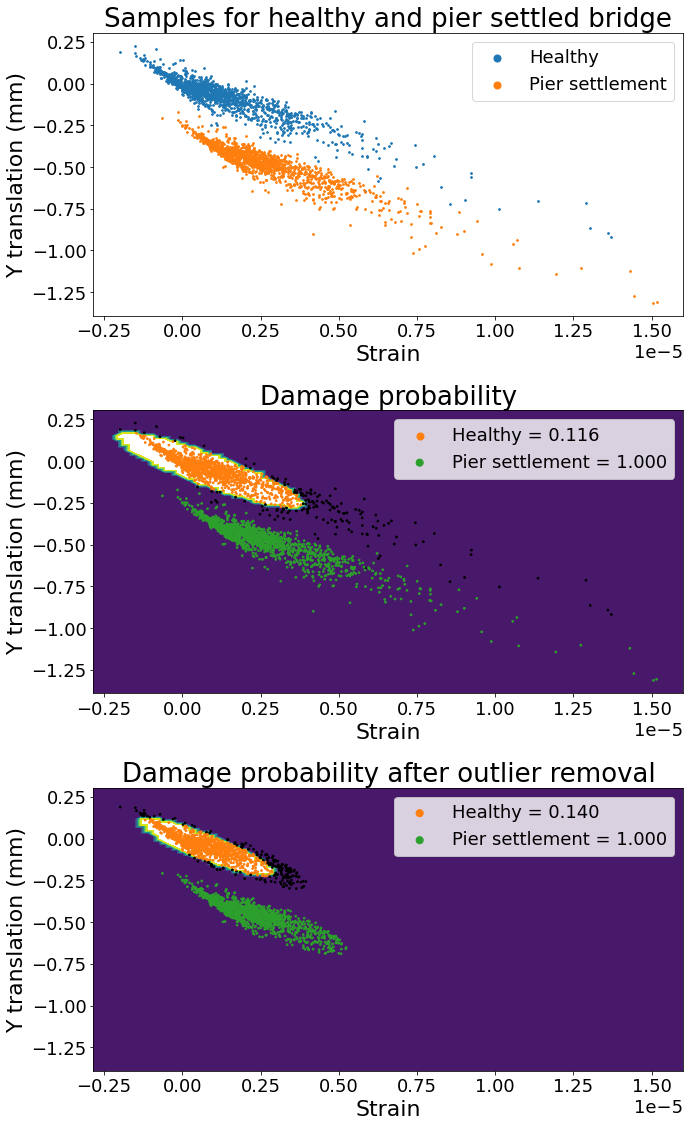

In [218]:
from sklearn.covariance import EllipticEnvelope

plt.portrait()

# Plot the raw data.
plt.subplot(3, 1, 1)
for damage_label in [1, 2]:
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Samples for healthy and pier settled bridge")
legend_marker_size(plt.legend(), 50)

# Choose a model.
model_f = EllipticEnvelope
# model_f = IsolationForest

# Fit the model to healthy/reference data.
model = model_f().fit(filter_for_label(damage_features, 0, damage_labels))

# Predict and determine accuracy of the model.
pred = model.predict(damage_features)
print(set(pred))
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1
        
# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")

# Plot the model results.
plt.subplot(3, 1, 2)
for damage_label in [1, 2]:
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label == 1 and p == 1) or (damage_label > 1 and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability")
legend = plt.legend()
legend_marker_size(legend, 50)
legend.legendHandles[0].set_color(colour(1))
plot_boundary(model)

#########################
# Now without outliers! #
#########################

og_damage_labels = damage_labels

# Remove the outliers.
new_damage_features, new_damage_labels = [], []
for damage_label in sorted(set(damage_labels)):
    print(f"Removing outliers for damage {damage_label}")
    df, dl = remove_outliers(
        model_f,
        filter_for_label(damage_features, damage_label, damage_labels),
        filter_for_label(damage_labels, damage_label, damage_labels),
    )
    new_damage_features.append(df), new_damage_labels.append(dl)
damage_features = np.concatenate(new_damage_features)
damage_labels = np.concatenate(new_damage_labels)
print(damage_features.shape)

# Fit the model to healthy/reference data.
model = model_f().fit(filter_for_label(damage_features, 0, damage_labels))

# Predict and determine accuracy of the model.
pred = model.predict(damage_features)
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")

# Plot the model results.
plt.subplot(3, 1, 3)
for damage_label in [1, 2]:
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    print(plot_features.shape)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label == 1 and p == 1) or (damage_label > 1 and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability after outlier removal")
legend_marker_size(plt.legend(), 50)
    
equal_lims("x", rows=3, cols=1)
equal_lims("y", rows=3, cols=1)
plot_boundary(model)
plt.tight_layout()
plt.savefig(c.get_image_path("classify/detection", "healthy-and-pier-comparison.pdf"))
plt.landscape()  # Keep as default.

# Simulation data with temperature effect

Responses of shape: (144001,)
INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600-mar/generated-data-images/bridge-705-med-3d/healthy/classify/detection/temp-and-damage.png


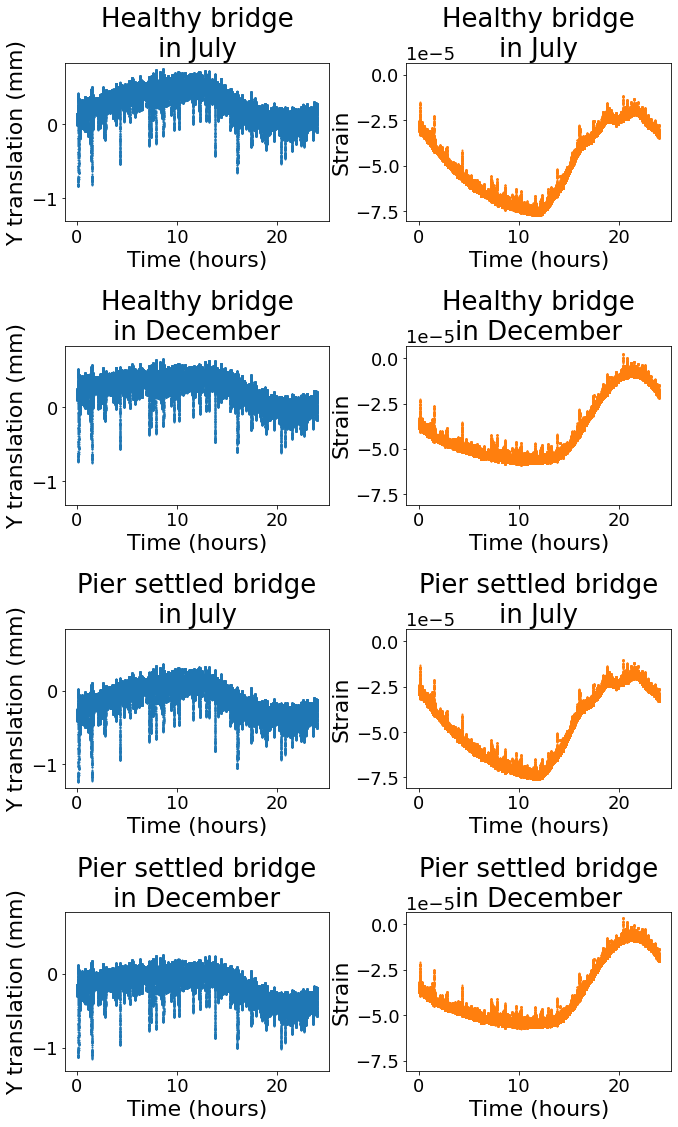

In [219]:
print(f"Responses of shape: {temp_effect_dec_y.shape}")
assert temp_effect_dec_y.shape == temp_effect_july_y.shape
assert responses.shape[-1] == temp_effect_dec_y.shape[0]

y_h, s_h = deepcopy(responses[1])  # Healthy bridge. Vertical translation and strain.
y_p, s_p = deepcopy(responses[2])  # Pier settlement. Vertical translation and strain.
y_h, y_p = resize_y(y_h), resize_y(y_p)
s_h, s_p = resize_s(s_h), resize_s(s_p)
x = np.arange(len(y_p)) * c.sensor_hz / 60

plt.portrait()

plt.subplot(4, 2, 1)
plt.scatter(x, y_h + temp_effect_july_y, s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin July")
plt.subplot(4, 2, 3)
plt.scatter(x, y_h + temp_effect_dec_y, s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin December")
plt.subplot(4, 2, 5)
plt.scatter(x, y_p + temp_effect_july_y, s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin July")
plt.subplot(4, 2, 7)
plt.scatter(x, y_p + temp_effect_dec_y, s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin December")
equal_lims("y", 4, 2, [1, 3, 5, 7])

plt.subplot(4, 2, 2)
plt.scatter(x, s_h + temp_effect_july_s, s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin July")
plt.subplot(4, 2, 4)
plt.scatter(x, s_h + temp_effect_dec_s, s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin December")
plt.subplot(4, 2, 6)
plt.scatter(x, s_p + temp_effect_july_s, s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin July")
plt.subplot(4, 2, 8)
plt.scatter(x, s_p + temp_effect_dec_s, s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin December")
equal_lims("y", 4, 2, [2, 4, 6, 8])

plt.tight_layout()
plt.landscape()
plt.savefig(c.get_image_path("classify/detection", "temp-and-damage.png"))

# Clustering with temperature effect
Clustering the first minute of data from each of the four scenarios above.

In [223]:
y_h_0, s_h_0 = deepcopy(responses[0])  # Healthy bridge reference data. Vertical translation and strain.
y_h, s_h = deepcopy(responses[1])  # Healthy bridge. Vertical translation and strain.
y_p, s_p = deepcopy(responses[2])  # Pier settlement. Vertical translation and strain.
y_h_0, y_h, y_p = resize_y(y_h_0), resize_y(y_h), resize_y(y_p)
s_h_0, s_h, s_p = resize_s(s_h_0), resize_s(s_h), resize_s(s_p)
x = np.arange(len(y_p)) * c.sensor_hz / 60

data_and_names = [
    (y_h + temp_effect_july_y, s_h + temp_effect_july_s, "Healthy bridge in July"),
    (y_h + temp_effect_dec_y, s_h + temp_effect_dec_s, "Healthy bridge in December"),
    (y_p + temp_effect_july_y, s_p + temp_effect_july_s, "Pier settled bridge in July"),
    (y_p + temp_effect_dec_y, s_p + temp_effect_dec_s, "Pier settled bridge in December"),
    (y_h_0 + temp_effect_july_y, s_h_0 + temp_effect_july_s, "Reference healthy bridge in July"),
]
damage_names = list(map(lambda x: x[2], data_and_names))

# First collect and label the responses.
damage_features = []  # Dimensions: ((scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (scenarios x samples per simulation), each value is the damage scenario index.
for label_i, (y, s, _name) in enumerate(data_and_names):
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(label_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)

# Downsample from 100 to 1 Hz.
downsample = int(1 / c.sensor_hz)
damage_features, damage_labels = damage_features[::downsample], damage_labels[::downsample]

print(damage_features.shape)
print(damage_labels.shape)
print(set(damage_labels))

(7201, 2)
(7201,)
{0, 1, 2, 3, 4}


Reference damage label = 4
{1, -1}
INFO: k = 0: 177 / 1441 = 0.12283136710617627
INFO: k = 1: 197 / 1440 = 0.13680555555555557
INFO: k = 2: 1438 / 1440 = 0.9986111111111111
INFO: k = 3: 1434 / 1440 = 0.9958333333333333
INFO: k = 4: 144 / 1440 = 0.1
Removing outliers for damage 0
Removing outliers for damage 1
Removing outliers for damage 2
Removing outliers for damage 3
Removing outliers for damage 4
INFO: k = 0: 155 / 1297 = 0.1195065535851966
INFO: k = 1: 309 / 1296 = 0.23842592592592593
INFO: k = 2: 1296 / 1296 = 1.0
INFO: k = 3: 1294 / 1296 = 0.9984567901234568
INFO: k = 4: 130 / 1296 = 0.10030864197530864
INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600-mar/generated-data-images/bridge-705-med-3d/healthy/classify/detection/healthy-and-pier-comparison.pdf


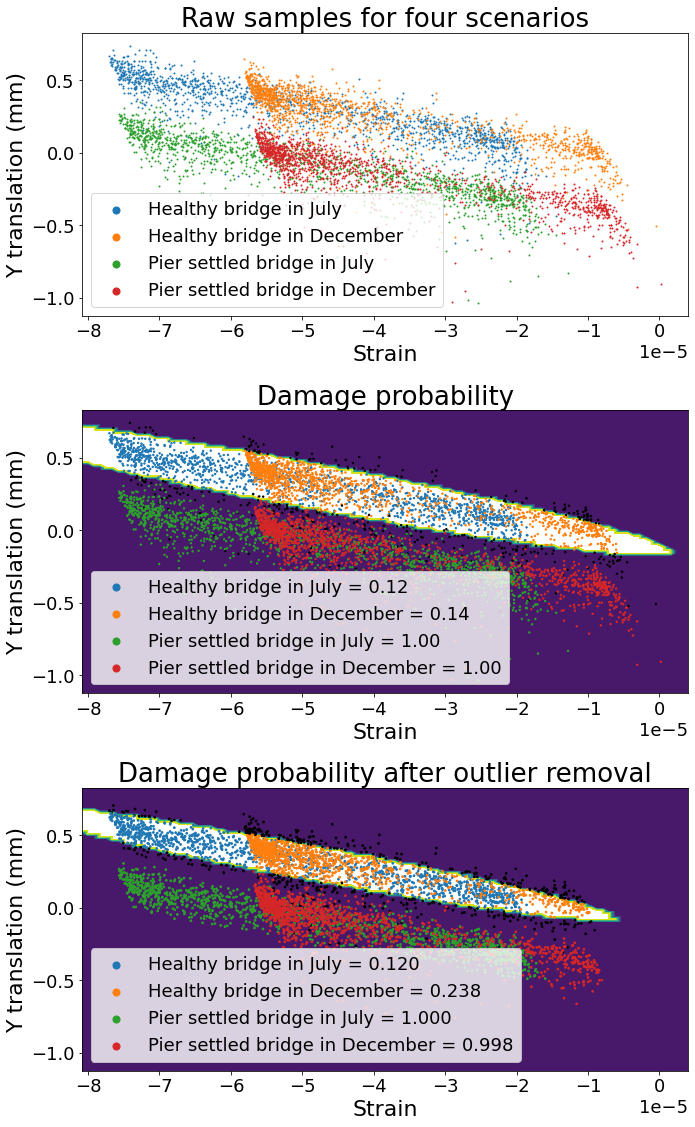

In [224]:
plt.portrait()

# Plot the raw data.
plt.subplot(3, 1, 1)
for damage_label in sorted(set(damage_labels))[:-1]:
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=1)
plt.title("Raw samples for four scenarios")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
legend = plt.legend()
for damage_label in sorted(set(damage_labels))[:-1]:
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

# Predict labels with a model.
ref_label = sorted(set(damage_labels))[-1]
model = model_f().fit(filter_for_label(damage_features, ref_label, damage_labels))
pred = model.predict(damage_features)
print(f"Reference damage label = {ref_label}")
print(set(pred))

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
healthy_labels = [0, 1]
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1
        
# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the damage detection results.
plt.subplot(3, 1, 2)
for damage_label in sorted(set(damage_labels))[:-1]:
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.2f}", s=2)
plt.title("Damage probability")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.legend()
plot_boundary(model)
legend = plt.legend()
for damage_label in sorted(set(damage_labels))[:-1]:
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

#########################
# Now without outliers! #
#########################

# Remove the outliers.
new_damage_features, new_damage_labels = [], []
for damage_label in set(damage_labels):
    print(f"Removing outliers for damage {damage_label}")
    df, dl = remove_outliers(
        model_f,
        filter_for_label(damage_features, damage_label, damage_labels),
        filter_for_label(damage_labels, damage_label, damage_labels)
    )
    new_damage_features.append(df), new_damage_labels.append(dl)
damage_features = np.concatenate(new_damage_features)
damage_labels = np.concatenate(new_damage_labels)

# Predict labels with a model.
ref_label = sorted(set(damage_labels))[-1]
model = model_f().fit(filter_for_label(damage_features, ref_label, damage_labels))
pred = model.predict(damage_features)

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the model results.
plt.subplot(3, 1, 3)
for damage_label in sorted(set(damage_labels))[:-1]:
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability after outlier removal")
legend = plt.legend()
for damage_label in sorted(set(damage_labels))[:-1]:
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

equal_lims("x", rows=3, cols=1)
equal_lims("y", rows=3, cols=1)
plot_boundary(model)
plt.tight_layout()
plt.savefig(c.get_image_path("classify/detection", "healthy-and-pier-comparison.pdf"))

# Removal of noise.

In [ ]:
# import numpy.polynomial.polynomial as poly
#     y_samples = list(map(lambda i: signal[int(i)], indices))
#     coefs = poly.polyfit(indices, y_samples, 3)
#     fit = poly.polyval(np.arange(0, len(signal)), coefs)
from scipy.signal import savgol_filter


def remove_temp(num_samples, signal, ref=None):
    """Data with outliers removed. Data must be of shape n samples x f features."""
    indices = list(map(int, np.linspace(0, len(signal) - 1, num_samples)))
    y_samples = []
    for i_lo, i_hi in zip(indices[:-1], indices[1:]):
        y_samples.append(np.mean(signal[i_lo:i_hi]))
    n =  np.interp(np.arange(len(signal)), indices[1:], y_samples)
    if ref is not None:
        error = deepcopy(signal) - n - ref
        return deepcopy(signal) - n, error
    return deepcopy(signal) - n

In [ ]:
y_h_48m, s_h_48m = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
# y_p_48m, s_p_48m = deepcopy(responses[1])  # Pier settlement. Vertical translation and strain.
len_24m = int(len(y_h_48m) / 2)
y_h_24m, s_h_24m = y_h_48m[:len_24m], s_h_48m[:len_24m]
# y_p_24m, s_p_24m = y_p_48m[:len_24m], s_p_48m[:len_24m]

# List of tuple (y translation time series, strain time series, name string).
# NOTE: these 24m time series are downsampled to from 100 to 1 Hz.
data = []
damage_names = []

# TODO: Add other months!
for day_i in range(1, 30 + 1):
    from_ = datetime.fromisoformat(f"2019-07-{('0' if day_i < 10 else '')  + str(day_i)}T00:00")
    to = datetime.fromisoformat(f"2019-07-{('0' if day_i < 9 else '') + str(day_i + 1)}T00:00")
    temps_day = temperature.from_to_mins(temps_year, from_, to)
    y_day = temperature.get_effect(c=c, response_type=rt_y, points=[point_a], temps=temps_day["temp"], responses=[y_h_24m], speed_up=60)[0]
    s_day = temperature.get_effect(c=c, response_type=rt_s, points=[point_a], temps=temps_day["temp"], responses=[y_h_24m], speed_up=60)[0]
    data.append((y_h_24m[::downsample], (y_h_24m + y_day)[::downsample], s_h_24m[::downsample], (s_h_24m + s_day)[::downsample]))
    damage_names.append(day_i)

In [ ]:
# Plotting the mean error against variance, doesn't show much!
y_error, y_var, s_error, s_var = [], [], [], []
for y_ref, y_temp, s_ref, s_temp in data:
    y_removed_temp, y_err = remove_temp(24, y_temp, ref=y_ref)
    s_removed_temp, s_err = remove_temp(24, s_temp, ref=s_ref)
    y_error.append(np.mean(y_err))
    s_error.append(s_err)
    y_var.append(np.var(y_temp))
# plt.scatter(y_error, y_var)

In [ ]:
plt.landscape()
ref = data[0][0]
signal = data[0][1]
removed_temp, error = remove_temp(24, signal, ref=ref)
plt.subplot(3, 1, 1)
plt.plot(ref)
plt.title("Data without daily temperature effect")
plt.subplot(3, 1, 2)
plt.plot(signal)
plt.title("Data with daily temperature effect")
plt.subplot(3, 1, 3)
# plt.plot(removed_temp - error, color="red")
plt.plot(removed_temp, label="After removal")
plt.plot(error, label=f"Mean error = {np.mean(error):.5f}")
plt.title("Removal of daily temperature effect")
plt.legend()
equal_lims("y", 3, 1)
plt.tight_layout()

In [ ]:
plt.portrait()

# First collect and label the responses.
damage_features = []  # Dimensions: ((scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (scenarios x samples per simulation), each value is the damage scenario index.
data_ = data[:3]  # TODO: Remove shortening of list!
for label_i, (y_ref, y_temp, s_ref, s_temp) in enumerate(list(data_)):
    y, s = resize_y(deepcopy(y_temp)), resize_s(deepcopy(s_temp))
    plt.subplot(len(data_), 1, label_i + 1)
    plt.plot(s)
    y = remove_outliers(model_f, remove_temp(24, y).reshape(-1, 1))
    s = remove_outliers(model_f, remove_temp(24, s).reshape(-1, 1))
    plt.plot(s)
#     y, s = remove_temp(24, y), remove_temp(48, s)
#     plt.subplot(len(data_and_names) * 2, 1, 1 + label_i * 2)
#     plt.plot(y)
#     print(y.shape, y_new.shape)
#     plt.subplot(len(data_and_names), 1, 1 + label_i)
#     plt.plot(y)
#     plt.plot(y - y_new, label="new")
#     print(y.shape)
#     print(r.shape)
#     plt.plot(y_r)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(label_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)
plt.legend()

# Experiment: long-term damage (pier settlement)
Here we run N simulations, combining removal techniques (daily & annual), and show how detection accuracy is changed.

In [ ]:
print(damage_features.shape)
print(damage_labels.shape)
print(set(damage_labels))

# Plot the reference data.
plt.subplot(3, 1, 1)
for damage_label in sorted(set(damage_labels)):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=1)
plt.title("Raw samples for four scenarios")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
legend = plt.legend()
for damage_label in set(damage_labels):
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

# Calculate labels with a model.
model = model_f().fit(filter_for_label(damage_features, 0, damage_labels))
pred = model.predict(damage_features)
print(set(pred))

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
healthy_labels = [0, 1]
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the damage detection results.
plt.subplot(3, 1, 2)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.2f}", s=2)
plt.title("Damage probability")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.legend()
plot_boundary(model)
# legend = plt.legend()
# for damage_label in set(damage_labels):
#     legend.legendHandles[damage_label].set_color(colour(damage_label))
# legend_marker_size(legend, 50)

#########################
# Now without outliers! #
#########################

# Remove the outliers.
new_damage_features, new_damage_labels = [], []
for damage_label in set(damage_labels):
    print(f"Removing outliers for damage {damage_label}")
    df, dl = remove_outliers(
        model_f,
        filter_for_label(damage_features, damage_label, damage_labels),
        filter_for_label(damage_labels, damage_label, damage_labels)
    )
    new_damage_features.append(df), new_damage_labels.append(dl)
damage_features = np.concatenate(new_damage_features)
damage_labels = np.concatenate(new_damage_labels)

# Predict on the new features without outliers.
pred = model.predict(damage_features)

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the model results.
plt.subplot(3, 1, 3)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability after outlier removal")
legend = plt.legend()
for damage_label in set(damage_labels):
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

equal_lims("x", rows=3, cols=1)
equal_lims("y", rows=3, cols=1)
plot_boundary(model)
plt.tight_layout()
plt.savefig(c.get_image_path("classify/detection", "healthy-and-pier-comparison.pdf"))

plt.landscape()  # Keep as default.

# Effect of distance from pier.

The distance a sensor is from a pier will affect the accuracy of damage detection.

In [ ]:
from plot.geometry import top_view_bridge
from util import flatten

pier_centers = [Point(x=pier.x, y=0, z=pier.z) for pier in c.bridge.supports]


def nearest_pier(point):
    """Index of nearest pier for a given point."""
    distance, nearest = np.inf, 0
    for pier_i, pier_point in enumerate(pier_centers):
        if point.distance(pier_point) < distance:
            distance = point.distance(pier_point)
            nearest = pier_i
    return nearest


# Number of sensors in X and Z directions.
X, Z = 200, 60
# X, Z = 100, 10
width, height = c.bridge.length / X, c.bridge.width / Z

# Sensors, as a grid.
grid_sensors = [
    [Point(x=x, y=0, z=z) for z in np.linspace(c.bridge.z_min + height / 2, c.bridge.z_max - height / 2, num=Z)]
    for x in np.linspace(c.bridge.x_min + width / 2, c.bridge.x_max - width / 2, num=X)
]
# Sensors, as a flattened list.
sensors = flatten(grid_sensors, Point)

# Selected pier, for each sensor.
sensor_piers = list(map(nearest_pier, sensors))

In [ ]:
top_view_bridge(c.bridge, compass=False, piers=True)
cmap = mpl.cm.get_cmap("tab10")
for sensor, pier in zip(sensors, sensor_piers):
    plt.gca().add_patch(plt.Rectangle(
        (sensor.x - width / 2, sensor.z - height / 2),
        width,
        height,
        facecolor=cmap(pier % 10),
        edgecolor="black",
    ))
plt.title("Sensors closest to each pier")
plt.close()

In [ ]:
# We downsample the traffic array before collecting responses
# because the number of points at which responses are collected
# is very lage making the calculation prohibitively expensive.

downsample = int(100 / 1)
down_traffic_array = np.array(traffic_array[::downsample])
print(traffic_array.shape)
print(down_traffic_array.shape)

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, damage_scenario in enumerate(damage_scenarios):
    for r_i, response_type in enumerate(response_types):
        print(f"Collecting responses for (damage, responses) = ({damage_scenario.name}, {response_type.name()})")
        responses[d_i][r_i] = responses_to_traffic_array(
            c=c,
            traffic_array=down_traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=sensors,
            sim_runner=OSRunner(c),
        ).T
responses = np.array(responses)
responses.shape

In [ ]:
from classify import without

# Remove unavailable sensors.
print(f"All sensors = {len(sensors)}")
without_f = without.without_sensors(c=c, pier_radius=1.5, track_radius=0.5)
classify_sensors = list(filter(lambda s: not without_f(s), sensors))
print(f"Available sensors = {len(classify_sensors)}")

# Limit to the sensors closes to pier 5.
# classify_sensors = set([sensor for sensor, pier in zip(sensors, sensor_piers) if pier == 5])

# Collect and label the responses.
damage_features = defaultdict(list)  # Dimensions: (sensors : (scenarios x samples per simulation) x features).
damage_labels = defaultdict(list)  # Dimensions: (sensors : (scenarios x samples per simulation)), each value is the damage scenario index.
for sensor_i, sensor in enumerate(sensors):
    if sensor in classify_sensors:
        print(f"Sensor {sensor_i}", end="\r")
        for damage_label, (y, s) in enumerate(responses):
            assert len(sensors) == len(y)
            y, s = resize_y(y[sensor_i]), resize_s(s[sensor_i])
            for response_i in range(len(y)):
                damage_features[sensor_i].append([y[response_i], s[response_i]])
                damage_labels[sensor_i].append(damage_label)
        damage_features[sensor_i] = np.array(damage_features[sensor_i])
        damage_labels[sensor_i] = np.array(damage_labels[sensor_i])
#         print(damage_features[sensor_i].shape)
#         print(damage_labels[sensor_i].shape)
#         print(set(damage_labels[sensor_i]))

In [ ]:
if True:
    acc_pier = dict()
    acc_healthy = dict()
    labels_pier = dict()
    labels_healthy = dict()
    for sensor_i, sensor in enumerate(sensors):
        if sensor in classify_sensors:
            healthy_features = filter_for_label(damage_features[sensor_i], 0, damage_labels[sensor_i])
            pier_features = filter_for_label(damage_features[sensor_i], 1, damage_labels[sensor_i])
            model = IsolationForest().fit(healthy_features)  # Train on healthy data.
            labels_healthy[sensor_i] = model.predict(healthy_features)  # Test on healthy data.
            labels_pier[sensor_i] = model.predict(pier_features)  # Test on pier settlement data.
            acc_pier[sensor_i] = len([x for x in labels_pier[sensor_i] if x == 1]) / len(labels_pier[sensor_i])
            acc_healthy[sensor_i] = len([x for x in labels_healthy[sensor_i] if x == 1]) / len(labels_healthy[sensor_i])
    #         print(f"Sensor {sensor_i}", acc_pier[sensor_i], acc_healthy[sensor_i], end="\r")
            print(f"Sensor {sensor_i}", end="\r")

In [ ]:
from scipy.spatial import distance

# For each sensor, the euclidean distance between the mean of
# the features under the healthy and damaged scenarios is
# calculated.
if False:
    dist = dict()  # <sensor index: mean>
    for sensor_i, sensor in enumerate(sensors):
        if sensor in classify_sensors:
            healthy_features = filter_for_label(damage_features[sensor_i], 0, damage_labels[sensor_i])
            pier_features = filter_for_label(damage_features[sensor_i], 1, damage_labels[sensor_i])
            healthy_mean = np.mean(healthy_features.T[0]), np.mean(healthy_features.T[1])
            pier_mean = np.mean(pier_features.T[0]), np.mean(pier_features.T[1])
            dist[sensor_i] = distance.euclidean(healthy_mean, pier_mean)
            print(f"Sensor {sensor_i}", end="\r")

In [ ]:
to_plot = acc_pier
# to_plot = dist
amin, amax = min(to_plot.values()), max(to_plot.values())
cmap = mpl.cm.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=amin, vmax=amax)

for sensor_i, (sensor, pier) in enumerate(zip(sensors, sensor_piers)):
    facecolor = cmap(1 - norm(to_plot[sensor_i])) if sensor in classify_sensors else "white"
    plt.gca().add_patch(plt.Rectangle(
        (sensor.x - width / 2, sensor.z - height / 2),
        width,
        height,
        facecolor=facecolor,
#         edgecolor="black",
    ))
top_view_bridge(c.bridge, compass=False, piers=True)

plt.title("Sensors detecting pier settlement in the absence of noise")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.savefig(c.get_image_path("classify/detection", "sensors-pier-detection.pdf"))

# Cracked concrete
Similar to pier settlement, we first show how the responses change under healthy and damaged scenario, except this time the damage scenario is cracked concrete rather than pier settlement.

In [ ]:
from classify.scenario.bridge import transverse_crack
    
damage_scenarios = [healthy_damage, transverse_crack()]
sensor = Point(x=52, y=0, z=-8.4)

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, damage_scenario in enumerate(damage_scenarios):
    for r_i, response_type in enumerate(response_types):
        print(f"Collecting responses for (damage, responses) = ({damage_scenario.name}, {response_type.name()})")
        responses[d_i][r_i] = responses_to_traffic_array(
            c=c,
            traffic_array=down_traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=[sensor],
            sim_runner=OSRunner(c),
        ).T
responses = np.array(responses)
responses.shape

In [ ]:
y_h, s_h = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
y_c, s_c = deepcopy(responses[1])  # Cracked bridge. Vertical translation and strain.
data_and_names = [
    (y_h + temp_effect_y[::downsample], s_h, "Healthy bridge in July"),
    (y_h + temp_effect_y_2[::downsample], s_h, "Healthy bridge in December"),
    (y_c + temp_effect_y[::downsample], s_c, "Cracked bridge in July"),
    (y_c + temp_effect_y_2[::downsample], s_c, "Cracked bridge in December"),
]
damage_names = list(map(lambda x: x[2], data_and_names))

# First collect and label the responses.
damage_features = []  # Dimensions: ((scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (scenarios x samples per simulation), each value is the damage scenario index.
for label_i, (y, s, _name) in enumerate(data_and_names):
    y, s = resize_y(y), resize_s(s)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(label_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)

print(damage_features.shape)
print(damage_labels.shape)
print(set(damage_labels))

In [ ]:
# Plot the reference data.
for damage_label in sorted(damage_labels)[::]:
    print(f"Damage label = {damage_label}", end="\r")
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=1)
plt.title("Reference data")
plt.legend()
plt.show()